In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

In [2]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

# load files 

In [3]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
direction = 'UD'

SVDnSTK = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\STK.mat'
                  , squeeze_me =True)
RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat'
                  , squeeze_me =True)

loadfiles = np.load(exp_folder+'\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)

In [4]:
r = RFprop['RF_properties']['radius']

In [5]:
RFprop = RFprop['RF_properties']

In [6]:
STK = SVDnSTK['gauss_RF']

In [7]:
cn = 9

In [8]:
dt=1/60 #large dt will cause  overflow
nstep = int(1./dt)
TKtaxis = np.arange(nstep)*dt
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]
TKAS = NGD2L_TK_AS(TKtaxis, *pd.DataFrame(para_dict).loc[cn-1][:-1])

# plot STK

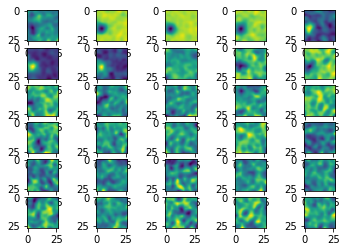

In [9]:
fig, ax = plt.subplots(6,5)
for i in range(30):
    ax.flatten()[i].imshow(STK[i,:,:,cn-1])

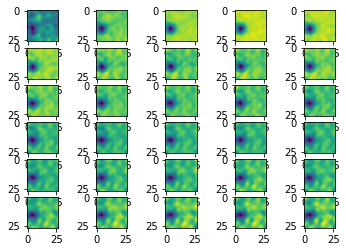

In [10]:
fig, ax = plt.subplots(6,5)
for i in range(30):
    ax.flatten()[i].imshow(np.sum(STK[:i+1,:,:,cn-1], axis = 0))

# SVD

In [11]:
rSTK = STK[:,:,:,cn-1].reshape((30,-1))
U,sigma,VT=np.linalg.svd(rSTK)

In [12]:
sigma/np.sum(sigma)

array([0.22944418, 0.04817011, 0.04382572, 0.04151995, 0.04055945,
       0.03855857, 0.03662413, 0.03300797, 0.03194516, 0.03164128,
       0.03057829, 0.03000371, 0.02937093, 0.0287208 , 0.02563969,
       0.02403461, 0.0237151 , 0.0233698 , 0.02218172, 0.02178813,
       0.01984652, 0.01918845, 0.01892579, 0.01715001, 0.01642189,
       0.01607936, 0.01553033, 0.01477941, 0.01450959, 0.01286938])

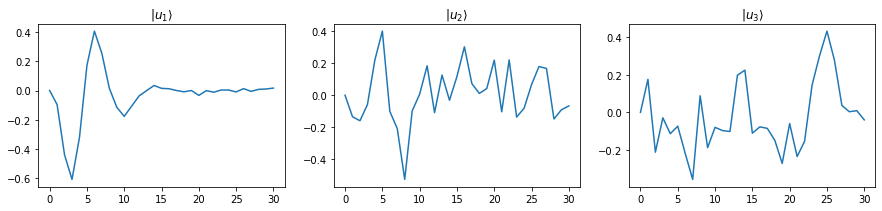

In [13]:
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax.flatten()[i].plot(np.append(0,U[:,i]))
ax.flatten()[0].set_title(r'$\left| u_1 \right\rangle$')
ax.flatten()[1].set_title(r'$\left| u_2 \right\rangle$')
ax.flatten()[2].set_title(r'$\left| u_3 \right\rangle$')
#     ax.flatten()[i].axes.xaxis.set_visible(False)
plt.gcf().set_size_inches(15, 3)

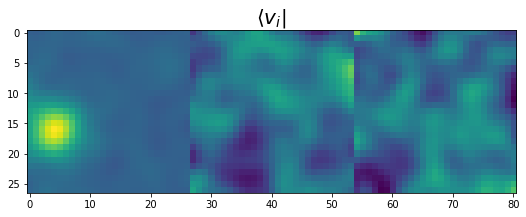

In [14]:
VTtogather=VT[0,:].reshape((27,27))
for i in np.arange(1,3):
    VTtogather = np.hstack((VTtogather, VT[i,:].reshape((27,27))))
plt.imshow(VTtogather)
plt.title(r'$\left\langle {v_i} \right|$', fontsize=20)

plt.gcf().set_size_inches(20, 3)

# STK vs SVD1STK

In [15]:
T_title = '0 ms'
for i in range(8):
    T_title += ('                 '+str(-1*np.round((i+1)/30, 3))+' ms')

In [16]:
T_title

'0 ms                 -0.033 ms                 -0.067 ms                 -0.1 ms                 -0.133 ms                 -0.167 ms                 -0.2 ms                 -0.233 ms                 -0.267 ms'

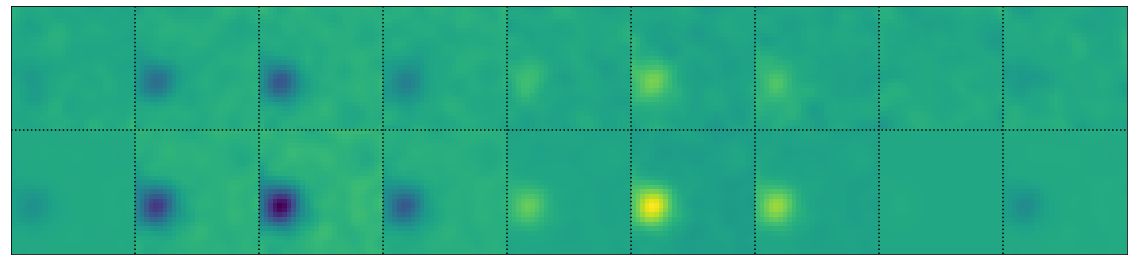

In [17]:
VTtogather =VT[0,:].reshape((27,27))* U[0,0]
STKtogather = STK[0,:,:,cn-1]
for i in np.arange(1,9):
    VTtogather = np.hstack((VTtogather, VT[0,:].reshape((27,27)) * U[i,0] ))
    STKtogather = np.hstack((STKtogather, STK[i,:,:,cn-1] ))
Togather = np.vstack((STKtogather, VTtogather))
fig, ax = plt.subplots(1,1)
ax.imshow(Togather)
ax.axhline(27-0.5, c='k',linestyle=':', zorder = 2)
for i in np.arange(1,9):
    ax.axvline(i*27-0.5, c='k',linestyle=':', zorder = 2)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

fig.set_size_inches(20, 5)

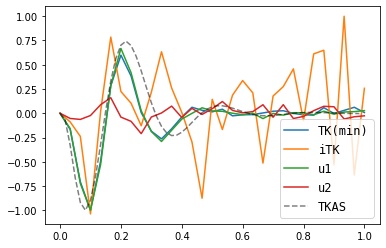

In [18]:
argminTK = STK[:,np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[1]
                          ,np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[2],cn-1]

iTK = np.sum(STK[:,:,:,cn-1], axis = (1,2))
plt.plot(np.arange(31)/30., np.append(0,argminTK)/-min(argminTK), label='TK(min)')
plt.plot(np.arange(31)/30., np.append(0,iTK)/min(iTK), label='iTK')
plt.plot(np.arange(31)/30., np.append(0,U[:,0]) /-min(U[:,0]), label='u1')
plt.plot(np.arange(31)/30., np.append(0,U[:,1]) /-min(U[:,1])*sigma[1]/sigma[0], label='u2')
plt.plot(TKtaxis, TKAS/-min(TKAS), 'k--', label = 'TKAS', alpha = 0.5)

plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

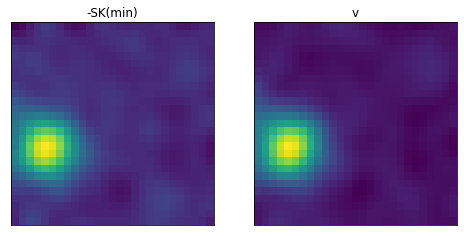

In [19]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(-STK[np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[0],:,:,cn-1]))
ax[0].set_title('-SK(min)')
ax[1].imshow(VT[0,:].reshape((27,27)))
ax[1].set_title('v')
for a in ax:
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)
fig.set_size_inches(8,6)

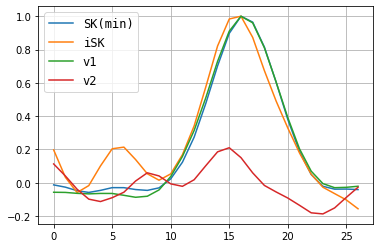

In [20]:
argminSKcut = np.squeeze(STK[np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[0],
                             :,
                             np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[2],  cn-1])
plt.plot(argminSKcut/ min(argminSKcut), label='SK(min)')

iSK = np.sum(STK[:15,:,:,cn-1], axis = 0)
iSKcut = np.squeeze(iSK[:, np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[2]])
plt.plot(iSKcut/ min(iSKcut), label='iSK')

v = VT[0,:].reshape((27,27))
vcut = v[:, np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[2]]
plt.plot(vcut/ max(vcut), label='v1')

v2 = VT[1,:].reshape((27,27))
v2cut = v2[:, np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[2]]
plt.plot(v2cut/ max(v2cut)*sigma[1]/sigma[0], label='v2')

plt.grid()

plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

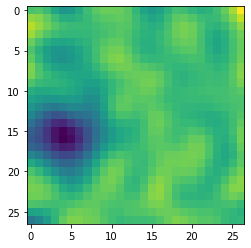

In [21]:
iSK = np.sum(STK[:15,:,:,cn-1], axis = 0)
plt.imshow(iSK)

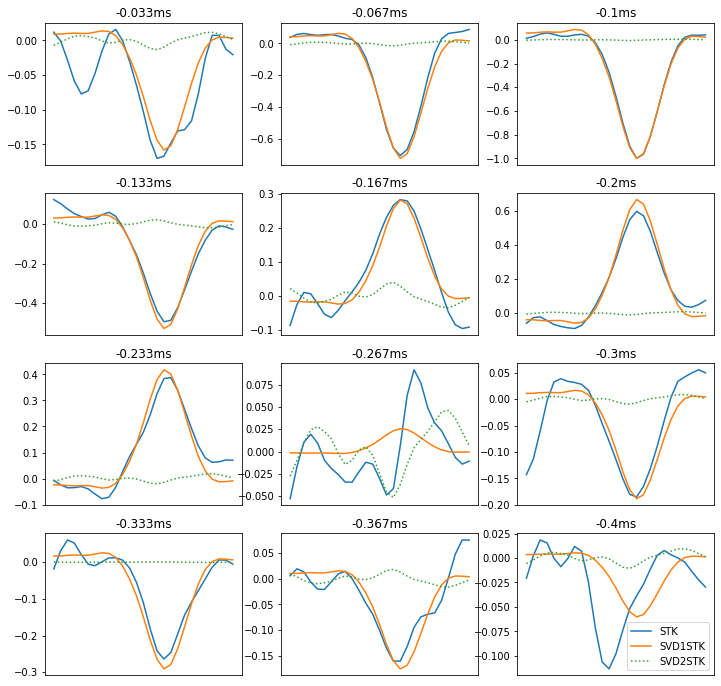

In [22]:
fig, ax = plt.subplots(4,3)
v = VT[0,:].reshape((27,27))
vcut = v[:, np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[2]]

v1 = VT[1,:].reshape((27,27))
v1cut = v1[:, np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[2]]
for i in range(12):
    argminSKcut = np.squeeze(STK[i, :, np.where(STK[:,:,:,cn-1] == np.min(STK[:,:,:,cn-1]))[2],  cn-1])
    ax.flatten()[i].plot(-argminSKcut/np.min(STK[:,:,:,cn-1]), label='STK')
    ax.flatten()[i].plot(-vcut*U[i,0]/max(vcut)/min(U[:,0]), label='SVD1STK')
    
    ax.flatten()[i].plot(-v1cut*U[i,1]/max(vcut)/min(U[:,0])*sigma[1]/sigma[0], ':',label='SVD2STK')
    
    ax.flatten()[i].set_title(str(-1*np.round((i+1)/30, 3))+'ms')
#     ax.flatten()[i].set_ylim([-1, -1*max(U[:,0])/min(U[:,0])+0.1])
    ax.flatten()[i].axes.xaxis.set_visible(False)
ax.flatten()[-1].legend(loc='best')
    
    
# fig.tight_layout()
fig.set_size_inches(12,12)

[ 0.19017196 16.20431578  2.661726  ]


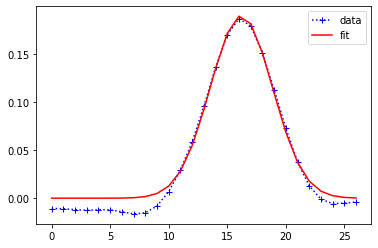

In [23]:
from scipy.optimize import curve_fit

def GF1d(x, a, x0, s):
    return  a*(np.exp(-((x-x0)/s)**2/2))


xaxis = np.arange(27.)
popt,pcov = curve_fit(GF1d, xaxis, np.squeeze(vcut),
                      p0=[max(vcut), 15., 3.], bounds = (0, np.inf))
# popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt)
plt.plot(vcut, 'b+:', label='data')
plt.plot(GF1d(xaxis, *popt), 'r-', label='fit')
plt.legend()

[1.62053980e+01 2.01583277e-01 2.92427377e+00 1.47332508e-02
 1.98549039e+01]


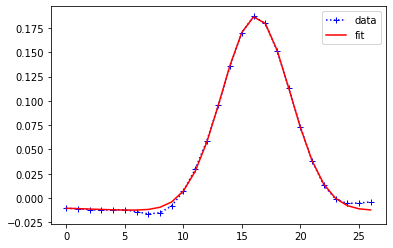

In [24]:
from scipy.optimize import curve_fit

def DoG(x, x0, a1, sigma1, a2, sigma2):
    return a1*(np.exp(-((x-x0)/sigma1)**2/2))-a2*(np.exp(-((x-x0)/sigma2)**2/2))


xaxis = np.arange(27.)
popt,pcov = curve_fit(DoG, xaxis, np.squeeze(vcut),
                      p0=[15., max(vcut), 3., 0.1*max(vcut), 10.], bounds = (0, np.inf))
print(popt)
plt.plot(vcut, 'b+:', label='data')
plt.plot(DoG(xaxis, *popt), 'r-', label='fit')
plt.legend()